In [ ]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

In [2]:
train = pd.read_csv("/home/ericjiang/workStation/temporary/titanic/train.csv")
test = pd.read_csv("/home/ericjiang/workStation/temporary/titanic/test.csv")

In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Remove Collinear Variables

In [4]:
# Threshold for removing correlated variables
threshold = 0.9
# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,0.005007,0.035144,0.036847,0.057527,0.001652,0.012658
Survived,0.005007,1.000000,0.338481,0.077221,0.035322,0.081629,0.257307
Pclass,0.035144,0.338481,1.000000,0.369226,0.083081,0.018443,0.549500
Age,0.036847,0.077221,0.369226,1.000000,0.308247,0.189119,0.096067
SibSp,0.057527,0.035322,0.083081,0.308247,1.000000,0.414838,0.159651
Parch,0.001652,0.081629,0.018443,0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,0.549500,0.096067,0.159651,0.216225,1.000000


In [5]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,NaN,0.005007,0.035144,0.036847,0.057527,0.001652,0.012658
Survived,NaN,NaN,0.338481,0.077221,0.035322,0.081629,0.257307
Pclass,NaN,NaN,NaN,0.369226,0.083081,0.018443,0.549500
Age,NaN,NaN,NaN,NaN,0.308247,0.189119,0.096067
SibSp,NaN,NaN,NaN,NaN,NaN,0.414838,0.159651
Parch,NaN,NaN,NaN,NaN,NaN,NaN,0.216225
Fare,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 0 columns to remove.


# Remove Missing Values

In [7]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

In [8]:
# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing

Cabin          0.782297
Age            0.205742
Fare           0.002392
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Embarked       0.000000
dtype: float64

In [9]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]
all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are {0} columns with more than 75%% missing values, columns is {1}'.format (len(all_missing) ,all_missing))

There are 1 columns with more than 75%% missing values, columns is ['Cabin']


In [10]:
train = train.drop(columns=all_missing)
test = test.drop(columns=all_missing)

In [11]:
print(train.shape)
print(test.shape)

(891, 11)
(418, 10)


# Fill up NULL

*  Train

In [12]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

In [13]:
train['Embarked'].value_counts().idxmax()

'S'

In [14]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].value_counts().idxmax())

In [15]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

In [16]:
train['Age'] = train['Age'].fillna(train['Age'].median())

In [17]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

*  Test

In [18]:
test.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64

In [19]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [20]:
test.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
dtype: int64

In [21]:
test['Age'] = test['Age'].fillna(test['Age'].median())

In [22]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [23]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [24]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,A.5. 3236,8.0500,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
416,1308,3,"Ware, Mr. Frederick",male,27.0,0,0,359309,8.0500,S


In [25]:
# pd.set_option('display.max_rows', None)

In [26]:
train['Ticket'].str.split(' ', expand = True)[1].fillna(train['Ticket'].str.split(' ', expand = True)[0])

0        21171
1        17599
2      3101282
3       113803
4       373450
        ...   
886     211536
887     112053
888       6607
889     111369
890     370376
Name: 1, Length: 891, dtype: object

In [27]:
train['Ticket'] = train['Ticket'].str.split(' ', expand = True)[1].fillna(train['Ticket'].str.split(' ', expand = True)[0])

In [28]:
test['Ticket'] = test['Ticket'].str.split(' ', expand = True)[1].fillna(test['Ticket'].str.split(' ', expand = True)[0])

In [29]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [30]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,3236,8.0500,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,17758,108.9000,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,3101262,7.2500,S
416,1308,3,"Ware, Mr. Frederick",male,27.0,0,0,359309,8.0500,S


In [31]:
train['Name'] = train['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0].str.strip()

In [32]:
test['Name'] = test['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0].str.strip()

In [33]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,Mr,male,22.0,1,0,21171,7.2500,S
1,2,1,1,Mrs,female,38.0,1,0,17599,71.2833,C
2,3,1,3,Miss,female,26.0,0,0,3101282,7.9250,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,Rev,male,27.0,0,0,211536,13.0000,S
887,888,1,1,Miss,female,19.0,0,0,112053,30.0000,S
888,889,0,3,Miss,female,28.0,1,2,6607,23.4500,S
889,890,1,1,Mr,male,26.0,0,0,111369,30.0000,C


In [34]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,Mr,male,34.5,0,0,330911,7.8292,Q
1,893,3,Mrs,female,47.0,1,0,363272,7.0000,S
2,894,2,Mr,male,62.0,0,0,240276,9.6875,Q
3,895,3,Mr,male,27.0,0,0,315154,8.6625,S
4,896,3,Mrs,female,22.0,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,Mr,male,27.0,0,0,3236,8.0500,S
414,1306,1,Dona,female,39.0,0,0,17758,108.9000,C
415,1307,3,Mr,male,38.5,0,0,3101262,7.2500,S
416,1308,3,Mr,male,27.0,0,0,359309,8.0500,S


In [35]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked'],
      dtype='object')

# lable encoding

In [36]:
from sklearn import preprocessing

In [37]:
df_train = train.drop(columns='PassengerId',axis=1)

In [38]:
le = preprocessing.LabelEncoder()

In [39]:
columns_name = ['Name','Sex','Ticket','Embarked']

for name in columns_name:
    df_train[name] = le.fit_transform(df_train[name])
df_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,11,1,22.0,1,0,162,7.2500,2
1,1,1,12,0,38.0,1,0,126,71.2833,0
2,1,3,8,0,26.0,0,0,343,7.9250,2
3,1,1,12,0,35.0,1,0,51,53.1000,2
4,0,3,11,1,35.0,0,0,595,8.0500,2
...,...,...,...,...,...,...,...,...,...,...
886,0,2,14,1,27.0,0,0,161,13.0000,2
887,1,1,8,0,19.0,0,0,15,30.0000,2
888,0,3,8,0,28.0,1,2,643,23.4500,2
889,1,1,11,1,26.0,0,0,9,30.0000,0


In [40]:
test = test.drop(columns='PassengerId',axis=1)
columns_name = ['Name','Sex','Ticket','Embarked']

for name in columns_name:
    test[name] = le.fit_transform(test[name])
test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,5,1,34.5,0,0,225,7.8292,1
1,3,6,0,47.0,1,0,301,7.0000,2
2,2,5,1,62.0,0,0,126,9.6875,1
3,3,5,1,27.0,0,0,219,8.6625,2
4,3,6,0,22.0,1,1,201,12.2875,2
...,...,...,...,...,...,...,...,...,...
413,3,5,1,27.0,0,0,221,8.0500,2
414,1,1,0,39.0,0,0,78,108.9000,0
415,3,5,1,38.5,0,0,194,7.2500,2
416,3,5,1,27.0,0,0,300,8.0500,2


In [41]:
df_train.shape

(891, 10)

In [42]:
test.shape

(418, 9)

# feature selection

In [43]:
train_labels = df_train['Survived']

In [44]:
df_train = df_train.drop(columns='Survived',axis=1)
df_train

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,11,1,22.0,1,0,162,7.2500,2
1,1,12,0,38.0,1,0,126,71.2833,0
2,3,8,0,26.0,0,0,343,7.9250,2
3,1,12,0,35.0,1,0,51,53.1000,2
4,3,11,1,35.0,0,0,595,8.0500,2
...,...,...,...,...,...,...,...,...,...
886,2,14,1,27.0,0,0,161,13.0000,2
887,1,8,0,19.0,0,0,15,30.0000,2
888,3,8,0,28.0,1,2,643,23.4500,2
889,1,11,1,26.0,0,0,9,30.0000,0


In [45]:
df_train.shape

(891, 9)

In [46]:
test.shape

(418, 9)

In [48]:
# from sklearn.ensemble import ExtraTreesClassifier

# model = ExtraTreesClassifier()
# model.fit(df_train, train_labels)
# print(model.feature_importances_)
# df_train.head()

In [ ]:
# df_train.drop(columns=['Ticket','Fare'],axis=1)

In [51]:
# Initialize an empty array to hold feature importances
# feature_importances = np.zeros(df_train.drop(columns=['Ticket','Fare'],axis=1).shape[1])
feature_importances = np.zeros(df_train.shape[1])
# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [53]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
#     train_features, valid_features, train_y, valid_y = train_test_split(df_train.drop(columns=['Ticket','Fare'],axis=1), train_labels, test_size = 0.25, random_state = i)
    train_features, valid_features, train_y, valid_y = train_test_split(df_train, train_labels, test_size = 0.25, random_state = i)
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.906047	valid_0's binary_logloss: 0.398827
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.840707	valid_0's binary_logloss: 0.485274


In [55]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
# feature_importances = pd.DataFrame({'feature': list(df_train.drop(columns=['Ticket','Fare'],axis=1).columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances = pd.DataFrame({'feature': list(df_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

,feature,importance
6,Ticket,349.0
7,Fare,285.0
3,Age,230.0
2,Sex,55.0
8,Embarked,52.0


In [56]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 0 features with 0.0 importance


,feature,importance
8,Embarked,52.0
0,Pclass,49.0
1,Name,41.0
4,SibSp,35.0
5,Parch,14.0


In [57]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

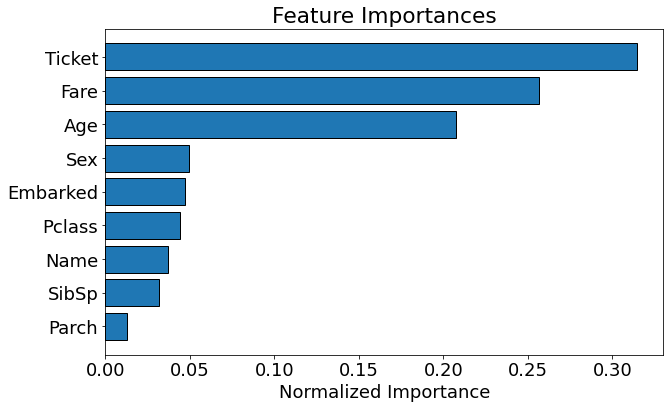

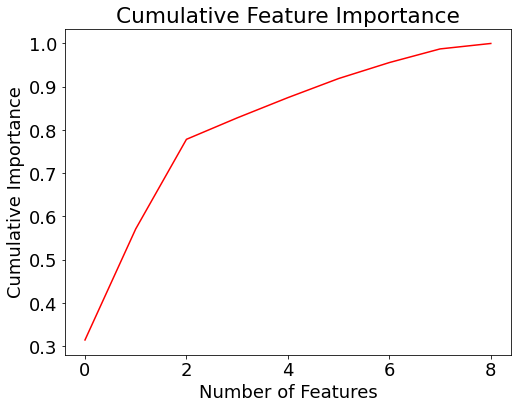

6 features required for 0.90 of cumulative importance


In [58]:
norm_feature_importances = plot_feature_importances(feature_importances)

# 建立模型

## 留前四個
```
Ticket
Fare
Age
```

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 26, max_depth = 8)

In [ ]:
X_train = train[['Age','Pclass','Embarked','Name']]

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, pd.get_dummies(X_train),train_labels, cv = 10)
print("十次分數:", scores)
# 由於 score 是 ndarray, 可以直接使用 average 來計算平均
import numpy as np
print("平均:", np.average(scores))

## 不刪除欄位

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, max_depth = 8)

In [ ]:
new_df = pd.get_dummies(train.drop(columns=['PassengerId','Survived'],axis=1))

In [ ]:
new_df

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, new_df,train_labels, cv = 20)
print("十次分數:", scores)
# 由於 score 是 ndarray, 可以直接使用 average 來計算平均
import numpy as np
print("平均:", np.average(scores))

# df_test

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, max_depth = 8)
clf = clf.fit(new_df,train_labels)

In [ ]:
df_test = test.drop(columns='PassengerId',axis=1)

In [ ]:
df_test = pd.get_dummies(df_test)

In [ ]:
print(new_df.shape)
df_test.shape

處理train有欄位但test沒有欄位

In [ ]:
miss_columns = set(new_df.columns) - set(df_test.columns)

In [ ]:
for col in miss_columns:
    df_test[col]=0

In [ ]:
print(new_df.shape)
df_test.shape

處理test有欄位但train沒有

In [ ]:
adu_columns = set(df_test.columns) - set(new_df.columns)

In [ ]:
df_test.drop(list(adu_columns),axis=1,inplace=True)

In [ ]:
print(new_df.shape)
df_test.shape

predict

In [ ]:
pre = clf.predict(df_test)

In [ ]:
pre

In [ ]:
result_df = pd.DataFrame(columns = ["PassengerId", "Survived"])

In [ ]:
result_df["PassengerId"] = test["PassengerId"]

In [ ]:
result_df['Survived'] = pre

In [ ]:
result_df

In [ ]:
result_df.to_csv("/home/ericjiang/workStation/temporary/titanic/result.csv",index=False)